In [2]:
import os, sys
import glob
import shutil
import zipfile
import numpy as np
from numpy.random import random, permutation
from keras import applications
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from IPython.display import FileLink
import itertools
from itertools import chain
from matplotlib import pyplot as plt
#import bcolz
import time


In [3]:
resnet_model = applications.ResNet50(weights='imagenet',include_top = True)

In [4]:
%matplotlib inline

In [5]:
data_path = "/home/ubuntu/nbs/data/kaggle_dogbreed/"
if not os.path.exists(data_path):
    os.mkdir(data_path)
    os.chdir(data_path)
    print(os.getcwd())
    !kg download -u 'susanmats@gmail.com' -p '9sctivcR' -c 'dog-breed-identification'
    #with os.scandir(data_path) as files:
    for file in os.scandir(data_path):
        if file.name.endswith('.zip'):
            print(os.stat(data_path + file.name).st_size, file.name)
            with zipfile.ZipFile(file.name, 'r') as z:
                z.extractall(data_path)
print(os.stat(data_path).st_size)
#with os.scandir(data_path) as files:
for file in os.scandir(data_path):
    print(file.name)
    os.chdir(data_path + 'train')
print('Train data sample')
!ls | head -n 5
!ls | tail -n 5
os.chdir(data_path + 'test')
print('Test data sample')
!ls | head -n 5
!ls |tail -n 5
os.chdir(data_path)

4096
train.zip
sample_submission.csv
processed_train
labels.csv.zip
labels.csv
test.csv
train
test.zip
processed_valid
test
processed_test
sample_submission.csv.zip
Train data sample
000bec180eb18c7604dcecc8fe0dba07.jpg
001513dfcb2ffafc82cccf4d8bbaba97.jpg
001cdf01b096e06d78e9e5112d419397.jpg
00214f311d5d2247d5dfe4fe24b2303d.jpg
0021f9ceb3235effd7fcde7f7538ed62.jpg
ls: write error: Broken pipe
ffd25009d635cfd16e793503ac5edef0.jpg
ffd3f636f7f379c51ba3648a9ff8254f.jpg
ffe2ca6c940cddfee68fa3cc6c63213f.jpg
ffe5f6d8e2bff356e9482a80a6e29aac.jpg
fff43b07992508bc822f33d8ffd902ae.jpg
Test data sample
000621fb3cbb32d8935728e48679680e.jpg
00102ee9d8eb90812350685311fe5890.jpg
0012a730dfa437f5f3613fb75efcd4ce.jpg
001510bc8570bbeee98c8d80c8a95ec1.jpg
001a5f3114548acdefa3d4da05474c2e.jpg
ls: write error: Broken pipe
ffeda8623d4eee33c6d1156a2ecbfcf8.jpg
fff1ec9e6e413275984966f745a313b0.jpg
fff74b59b758bbbf13a5793182a9bbe4.jpg
fff7d50d848e8014ac1e9172dc6762a3.jpg
fffbff22c1f51e3dc80c4bf04089545b.jpg


In [6]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

In [7]:
INPUT_SIZE = 224
NUM_CLASSES = 64
SEED = 1987
data_dir = '/home/ubuntu/nbs/data/kaggle_dogbreed/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [8]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))

In [9]:
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [10]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img


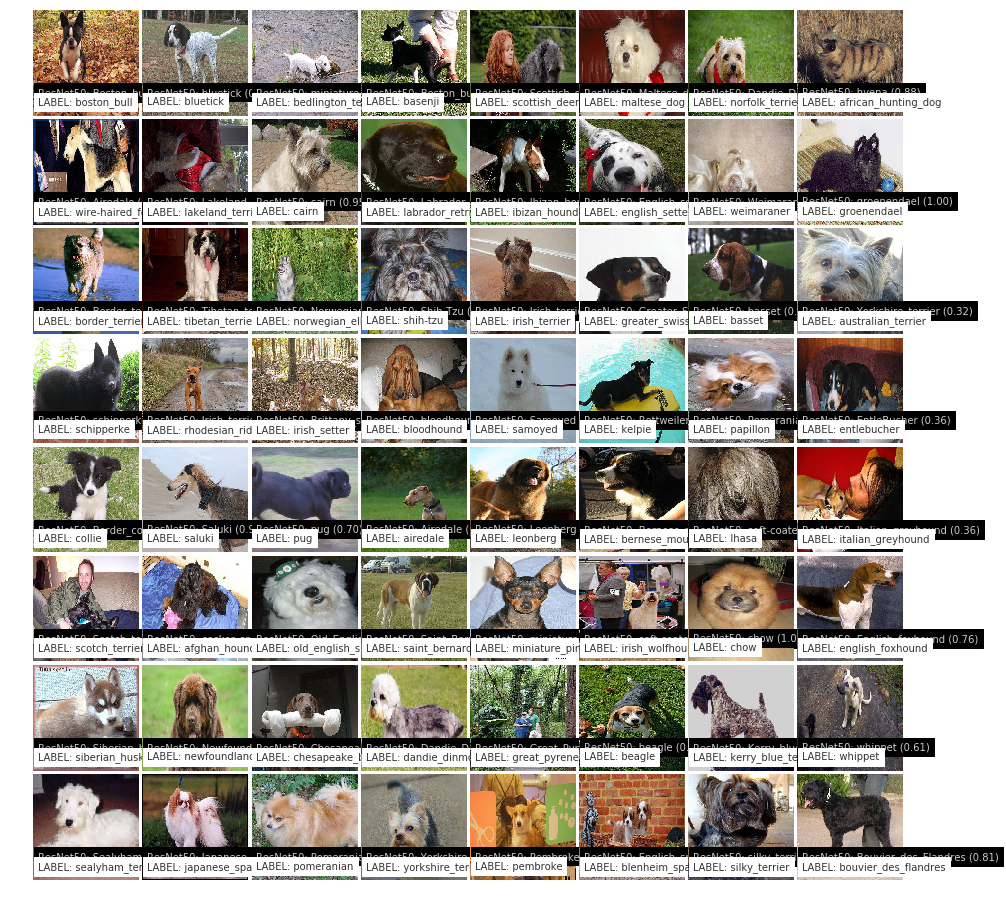

In [11]:
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = resnet_model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

In [12]:
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [13]:
from keras.models import Model
new_layer = Dense(120, activation='softmax', name='predictions')
inp = resnet_model.input
out = new_layer(resnet_model.layers[-1].output)
model2 = Model(inp, out)

In [14]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [15]:
from keras.preprocessing import image
import numpy as np

def load_test_image(fpath):
    img = image.load_img(fpath, target_size=(224, 224))
    x = image.img_to_array(img)
    return x

test_labels = np.loadtxt('/home/ubuntu/nbs/data/kaggle_dogbreed/sample_submission.csv', delimiter=',', dtype=str, skiprows=1)
test_images = []
test_names = test_labels[:,0]
for test_name in test_names:
    fname = '{}.jpg'.format(test_name)
    data = load_test_image(os.path.join('/home/ubuntu/nbs/data/kaggle_dogbreed/test/', fname))
    test_images.append(data)

test_images = np.asarray(test_images)
test_images = test_images.astype('float32')
test_images /= 255
print(test_images.shape)

(10357, 224, 224, 3)


In [16]:
predictions = model2.predict(test_images, verbose=1)

10357/10357 [==============================] - 99s 10ms/step


In [17]:
test_df = pd.DataFrame(predictions)
sample_sub_csv = '/home/ubuntu/nbs/data/kaggle_dogbreed/sample_submission.csv'
df_sample_sub = pd.read_csv(sample_sub_csv, index_col='id')

In [18]:
# Get column names from sample_submission.csv
sub_columns = df_sample_sub.columns

In [19]:
# Sanity check - print first 3 rows of test preds pandas dataframe.
test_df.head(n=3)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.008271,0.008306,0.008433,0.008413,0.008343,0.008258,0.008274,0.008262,0.008259,0.008396,...,0.008316,0.008286,0.008274,0.008213,0.008377,0.008310,0.008273,0.008267,0.008363,0.008376
1,0.008281,0.008318,0.008430,0.008395,0.008342,0.008277,0.008292,0.008267,0.008276,0.008385,...,0.008316,0.008297,0.008294,0.008230,0.008369,0.008321,0.008293,0.008284,0.008347,0.008359
2,0.008278,0.008308,0.008428,0.008400,0.008344,0.008269,0.008281,0.008269,0.008269,0.008388,...,0.008318,0.008291,0.008284,0.008225,0.008376,0.008314,0.008281,0.008276,0.008360,0.008369
